In [ ]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 4.9 MB/s 
     |████████████████████████████████| 9.9 MB 43.8 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196208 sha256=630fa4892131b0c56e690da32ecd4908228b01ebc03bb20396150330b2b8cda6
  Stored in directory: /root/.cache/pip/wheels/75/b0/89/f6866fc5accea9bec04f4c9f2a242520d6e8e7b8fcf89e139c
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=f6777d19731b2ca5fa576976d36244e8c6f2e54fc83b0eb5d9b15a7076dae8c7
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path
import community.community_louvain as cl
import pingouin as pg

#Carga de datos

In [ ]:
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
!unzip -q DataSujetos

In [ ]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densisdad de aristas correspondiente
    """
    
    correlation_matrix = pd.read_csv(filename, header=None)
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

In [ ]:
filenames_N1 = list(Path('DataSujetos').glob('N1_*.csv'))
filenames_N2 = list(Path('DataSujetos').glob('N2_*.csv'))
filenames_N3 = list(Path('DataSujetos').glob('N3_*.csv'))
filenames_W  = list(Path('DataSujetos').glob('W_*.csv'))

In [ ]:
densities = np.linspace(0.025,0.2,10)
graphs_N1 = {}
for filename in filenames_N1:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N1[name] = Gs
graphs_N2 = {}
for filename in filenames_N2:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N2[name] = Gs
graphs_N3 = {}
for filename in filenames_N3:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N3[name] = Gs
graphs_W = {}
for filename in filenames_W:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_W[name] = Gs

#Cálculo de métricas

In [ ]:
def max_degree(G):
  degree = dict(G.degree)
  return np.max(list(degree.values()))

In [ ]:
def min_degree(G):
  degree = dict(G.degree)
  return np.min(list(degree.values()))

In [ ]:
def avg_shortest_path(G):
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
  G = G.subgraph(Gcc[0])
  return nx.average_shortest_path_length(G)

In [ ]:
def avg_betweenness(G):
  betweenness = nx.betweenness_centrality(G)
  return np.mean(list(betweenness.values()))

In [ ]:
def avg_closeness(G):
  closeness = nx.closeness_centrality(G)
  return np.mean(list(closeness.values()))

In [ ]:
def avg_eigenvector(G):
  eigenvector = nx.eigenvector_centrality(G, max_iter = 500)
  return np.mean(list(eigenvector.values()))

In [ ]:
def avg_clustering(G):
  clustering = nx.clustering(G)
  return np.mean(list(clustering.values()))

In [ ]:
def metrics(graph_dict,densities):
  data_dict = {'subject': [],
       'state'  : [],
       'density': [],
       'maxD'   : [],
       'minD'   : [],
       'spath'  : [],
       'betw'   : [],
       'close'  : [],
       'eigen'  : [],
       'clust'  : []}
  for subject,Gs in graph_dict.items():
    for i,d in enumerate(densities):
      maxD  = max_degree(Gs[i])
      minD  = min_degree(Gs[i])
      spath = avg_shortest_path(Gs[i])
      betw  = avg_betweenness(Gs[i])
      close = avg_closeness(Gs[i])
      eigen = avg_eigenvector(Gs[i])
      clust = avg_clustering(Gs[i])
      s = subject.split('_')
      data_dict['subject'].append(s[1])
      data_dict['state'].append(s[0])
      data_dict['density'].append(d)
      data_dict['maxD'].append(maxD)
      data_dict['minD'].append(minD)
      data_dict['spath'].append(spath)
      data_dict['betw'].append(betw)
      data_dict['close'].append(close)
      data_dict['eigen'].append(eigen)
      data_dict['clust'].append(clust)
      #print(list(modules.items()))
  return pd.DataFrame(data = data_dict)

In [ ]:
#metrics(graphs_N1,densities)

In [ ]:
metrics_N1 = metrics(graphs_N1,densities)
metrics_N2 = metrics(graphs_N2,densities)
metrics_N3 = metrics(graphs_N3,densities)
metrics_W  = metrics(graphs_W ,densities)

In [ ]:
df = pd.concat([metrics_N1,metrics_N2,metrics_N3,metrics_W])

In [ ]:
df

,subject,state,density,maxD,minD,spath,betw,close,eigen,clust
0,suj5,N1,0.025000,11,0,5.288850,0.012851,0.070136,0.042408,0.311047
1,suj5,N1,0.044444,22,0,4.317647,0.015576,0.132848,0.048977,0.375027
2,suj5,N1,0.063889,27,0,3.345353,0.013772,0.208853,0.052196,0.466837
3,suj5,N1,0.083333,31,0,2.981529,0.012135,0.245288,0.056616,0.467080
4,suj5,N1,0.102778,37,0,2.975875,0.015295,0.311618,0.059473,0.513417
...,...,...,...,...,...,...,...,...,...,...
175,suj2,W,0.122222,42,0,3.490909,0.016216,0.228807,0.060689,0.587371
176,suj2,W,0.141667,48,0,3.199124,0.015192,0.263753,0.062708,0.606070
177,suj2,W,0.161111,49,0,2.987060,0.015954,0.322735,0.064184,0.601191
178,suj2,W,0.180556,53,0,2.849795,0.014852,0.338689,0.065643,0.633270


#Tests estadísticos

##Verificando supuestos

In [ ]:
#pg.normality(df.w)
norm = df.drop(['subject'], axis = 1).groupby(by = ['state','density']).apply(pg.normality)

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [ ]:
norm.head(120)

W      pval  normal
state density                                     
N1    0.025000 density  1.000000  1.000000    True
               maxD     0.879856  0.025959   False
               minD     1.000000  1.000000    True
               spath    0.931893  0.209638    True
               betw     0.921582  0.137885    True
...                          ...       ...     ...
N2    0.102778 spath    0.936935  0.256647    True
               betw     0.910032  0.086146    True
               close    0.957110  0.546935    True
               eigen    0.895398  0.047803   False
               clust    0.933797  0.226345    True

[120 rows x 3 columns]

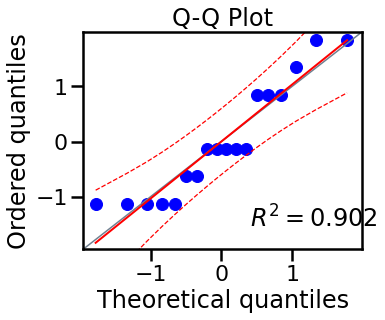

In [ ]:
pg.qqplot(df.drop(['subject'], axis = 1).loc[(df.state == 'N1') & (df.density == 0.025),'maxD'], dist='norm');

In [ ]:
def norm_var(df_norm,var):
  return df_norm.reset_index().loc[norm.reset_index().level_2 == var].groupby(by = 'density').apply(lambda x: min(x.normal))

In [ ]:
norm_maxD = norm_var(norm,'maxD')
norm_maxD

density
0.025000    False
0.044444     True
0.063889    False
0.083333     True
0.102778     True
0.122222    False
0.141667     True
0.161111     True
0.180556     True
0.200000     True
dtype: bool

In [ ]:
norm_minD = norm_var(norm,'minD')
norm_minD

density
0.025000     True
0.044444     True
0.063889     True
0.083333     True
0.102778    False
0.122222    False
0.141667    False
0.161111    False
0.180556    False
0.200000    False
dtype: bool

In [ ]:
norm_spath = norm_var(norm,'spath')
norm_spath

density
0.025000     True
0.044444    False
0.063889     True
0.083333    False
0.102778    False
0.122222    False
0.141667    False
0.161111    False
0.180556    False
0.200000    False
dtype: bool

In [ ]:
norm_betw = norm_var(norm,'betw')
norm_betw

density
0.025000    False
0.044444    False
0.063889     True
0.083333     True
0.102778     True
0.122222    False
0.141667    False
0.161111    False
0.180556    False
0.200000    False
dtype: bool

In [ ]:
norm_close = norm_var(norm,'close')
norm_close

density
0.025000    False
0.044444     True
0.063889     True
0.083333     True
0.102778    False
0.122222    False
0.141667    False
0.161111    False
0.180556    False
0.200000    False
dtype: bool

In [ ]:
norm_eigen = norm_var(norm,'eigen')
norm_eigen

density
0.025000     True
0.044444     True
0.063889     True
0.083333    False
0.102778    False
0.122222    False
0.141667     True
0.161111     True
0.180556     True
0.200000     True
dtype: bool

In [ ]:
norm_clust = norm_var(norm,'clust')
norm_clust

density
0.025000     True
0.044444     True
0.063889     True
0.083333    False
0.102778     True
0.122222     True
0.141667     True
0.161111     True
0.180556     True
0.200000     True
dtype: bool

In [ ]:
def sphere_var(df,var):
  return df.groupby(by = ['density']).apply(lambda x: pg.sphericity(x,dv = var,within = 'state',subject = 'subject')[0])

In [ ]:
sphere_maxD = sphere_var(df,'maxD')
sphere_maxD

density
0.025000    True
0.044444    True
0.063889    True
0.083333    True
0.102778    True
0.122222    True
0.141667    True
0.161111    True
0.180556    True
0.200000    True
dtype: bool

In [ ]:
sphere_minD = sphere_var(df,'minD')
sphere_minD

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


density
0.025000     True
0.044444     True
0.063889     True
0.083333     True
0.102778     True
0.122222     True
0.141667     True
0.161111     True
0.180556    False
0.200000    False
dtype: bool

In [ ]:
sphere_spath = sphere_var(df,'spath')
sphere_spath

density
0.025000    False
0.044444     True
0.063889     True
0.083333     True
0.102778     True
0.122222     True
0.141667     True
0.161111    False
0.180556    False
0.200000     True
dtype: bool

In [ ]:
sphere_betw = sphere_var(df,'betw')
sphere_betw

density
0.025000    True
0.044444    True
0.063889    True
0.083333    True
0.102778    True
0.122222    True
0.141667    True
0.161111    True
0.180556    True
0.200000    True
dtype: bool

In [ ]:
sphere_close = sphere_var(df,'close')
sphere_close

density
0.025000    True
0.044444    True
0.063889    True
0.083333    True
0.102778    True
0.122222    True
0.141667    True
0.161111    True
0.180556    True
0.200000    True
dtype: bool

In [ ]:
sphere_eigen = sphere_var(df,'eigen')
sphere_eigen

density
0.025000    True
0.044444    True
0.063889    True
0.083333    True
0.102778    True
0.122222    True
0.141667    True
0.161111    True
0.180556    True
0.200000    True
dtype: bool

In [ ]:
sphere_clust = sphere_var(df,'clust')
sphere_clust

density
0.025000    True
0.044444    True
0.063889    True
0.083333    True
0.102778    True
0.122222    True
0.141667    True
0.161111    True
0.180556    True
0.200000    True
dtype: bool

Casi todo cumple con esfericidad, así que basta con revisar la normalidad para ver si cumple los requisitos



##Análisis de varianza (medidas repetidas)

In [ ]:
def var_test(x,var,norm,adj):
  #la condición está escrita espantosamente, para la densidad de cada grupo chequeo si es normal para decidir el test, la esfericidad casi no es un factor
  if np.mean(norm[x.density]):
    p = pg.rm_anova(x,dv = var,within = 'state',subject = 'subject')
  else:
    p = pg.friedman(x,dv = var,within = 'state',subject = 'subject',method = 'f')
  #p['p-corr'] = adj * p['p-unc']
  if 'p-unc' not in p:
    p['p-unc'] = 1 
  p['significant'] = p['p-unc'] < (0.05 / adj)
  return p.loc[:,['p-unc','significant']]

In [ ]:
def var_analysis(df,var,norm, adj = 5):
  return df.groupby(by = ['density']).apply(lambda x: var_test(x,var,norm,adj)).droplevel(1)

In [ ]:
var_maxD = var_analysis(df,'maxD',norm_maxD)
var_maxD

,p-unc,significant
density,,
0.025000,0.257641,False
0.044444,0.232608,False
0.063889,0.290609,False
0.083333,0.987792,False
0.102778,0.951073,False
0.122222,0.869686,False
0.141667,0.935572,False
0.161111,0.554977,False
0.180556,0.910035,False


In [ ]:
var_minD = var_analysis(df,'minD',norm_minD)
var_minD

/usr/local/lib/python3.8/dist-packages/pingouin/parametric.py:566: RuntimeWarning: invalid value encountered in double_scalars
  fval = ms_with / ms_reswith
/usr/local/lib/python3.8/dist-packages/pingouin/parametric.py:576: RuntimeWarning: invalid value encountered in double_scalars
  ef = ss_with / (ss_with + ss_resall)
/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:714: RuntimeWarning: invalid value encountered in double_scalars
  eps = np.min([num / den, 1])


,p-unc,significant
density,,
0.025000,1.000000,False
0.044444,1.000000,False
0.063889,1.000000,False
0.083333,1.000000,False
0.102778,0.398570,False
0.122222,0.578797,False
0.141667,1.000000,False
0.161111,0.861619,False
0.180556,0.634321,False


In [ ]:
var_spath = var_analysis(df,'spath',norm_spath)
var_spath

,p-unc,significant
density,,
0.025000,0.750050,False
0.044444,0.089714,False
0.063889,0.079658,False
0.083333,0.129309,False
0.102778,0.163928,False
0.122222,0.244933,False
0.141667,0.289247,False
0.161111,0.635082,False
0.180556,0.129309,False


In [ ]:
var_betw = var_analysis(df,'betw',norm_betw)
var_betw

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,p-unc,significant
density,,
0.025000,0.513173,False
0.044444,0.061558,False
0.063889,0.020885,False
0.083333,0.010796,False
0.102778,0.049990,False
0.122222,0.244933,False
0.141667,0.173796,False
0.161111,0.305476,False
0.180556,0.231538,False


In [ ]:
var_close = var_analysis(df,'close',norm_close)
var_close

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,p-unc,significant
density,,
0.025000,0.740351,False
0.044444,0.014873,False
0.063889,0.023890,False
0.083333,0.165195,False
0.102778,0.281414,False
0.122222,0.358858,False
0.141667,0.189597,False
0.161111,0.023726,False
0.180556,0.137278,False


In [ ]:
var_eigen = var_analysis(df,'eigen',norm_eigen)
var_eigen

/usr/local/lib/python3.8/dist-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,p-unc,significant
density,,
0.025000,0.524581,False
0.044444,0.620440,False
0.063889,0.945214,False
0.083333,0.995011,False
0.102778,0.976432,False
0.122222,0.834369,False
0.141667,0.667265,False
0.161111,0.346716,False
0.180556,0.235426,False


In [ ]:
var_clust = var_analysis(df,'clust',norm_clust)
var_clust

,p-unc,significant
density,,
0.025000,0.033691,False
0.044444,0.067063,False
0.063889,0.069086,False
0.083333,0.014156,False
0.102778,0.054071,False
0.122222,0.062615,False
0.141667,0.140179,False
0.161111,0.170918,False
0.180556,0.429304,False


##Tests post-hoc

Usar parametric = True en el caso de que se pueda usar tests paramétricos

In [ ]:
def pairwise_test(x,var,norm,adj):
  #la condición está escrita espantosamente, para la densidad de cada grupo chequeo si es normal para decidir el test, la esfericidad casi no es un factor
  if np.mean(norm[x.density]):
    p = pg.pairwise_tests(x,dv = var,within = 'state',subject = 'subject',parametric = True)
  else:
    p = pg.pairwise_tests(x,dv = var,within = 'state',subject = 'subject',parametric = False)
  #p['p-corr'] = adj * p['p-unc']
  if 'p-unc' not in p:
    p['p-unc'] = 1
  p['significant'] = p['p-unc'] < (0.05 / adj)
  return p.loc[:,['A','B','p-unc','significant']]

In [ ]:
def pairwise_analysis(df,var,norm, adj = 6):
  return df.groupby(by = ['density']).apply(lambda x: pairwise_test(x,var,norm,adj))#.droplevel(1)

In [ ]:
pairwise_maxD = pairwise_analysis(df,'maxD',norm_maxD)
var_maxD

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,p-unc,significant
density,,
0.025000,0.257641,False
0.044444,0.232608,False
0.063889,0.290609,False
0.083333,0.987792,False
0.102778,0.951073,False
0.122222,0.869686,False
0.141667,0.935572,False
0.161111,0.554977,False
0.180556,0.910035,False


In [ ]:
#pairwise_minD = pairwise_analysis(df,'minD',norm_minD)
#var_minD

In [ ]:
pairwise_spath = pairwise_analysis(df,'spath',norm_spath)
var_spath

,p-unc,significant
density,,
0.025000,0.750050,False
0.044444,0.089714,False
0.063889,0.079658,False
0.083333,0.129309,False
0.102778,0.163928,False
0.122222,0.244933,False
0.141667,0.289247,False
0.161111,0.635082,False
0.180556,0.129309,False


In [ ]:
pairwise_betw = pairwise_analysis(df,'betw',norm_betw)
pairwise_betw

A   B     p-unc  significant
density                                  
0.025000 0  N1  N2  0.495079        False
         1  N1  N3  0.283730        False
         2  N1   W  0.609459        False
         3  N2  N3  0.212143        False
         4  N2   W  0.346550        False
         5  N3   W  0.865044        False
0.044444 0  N1  N2  0.181465        False
         1  N1  N3  0.030365        False
         2  N1   W  0.303795        False
         3  N2  N3  0.303795        False
         4  N2   W  0.865044        False
         5  N3   W  0.081429        False
0.063889 0  N1  N2  0.030655        False
         1  N1  N3  0.001360         True
         2  N1   W  0.192492        False
         3  N2  N3  0.500186        False
         4  N2   W  0.322610        False
         5  N3   W  0.107896        False
0.083333 0  N1  N2  0.016344        False
         1  N1  N3  0.006343         True
         2  N1   W  0.761371        False
         3  N2  N3  0.388775        False
         4  N2   W  0.113965        False
         5  N3   W  0.025287        False
0.102778 0  N1  N2  0.298054        False
         1  N1  N3  0.084241        False
         2  N1   W  0.289034        False
         3  N2  N3  0.559775        False
         4  N2   W  0.119698        False
         5  N3   W  0.006975         True
0.122222 0  N1  N2  0.167351        False
         1  N1  N3  0.154045        False
         2  N1   W  0.346550        False
         3  N2  N3  1.000000        False
         4  N2   W  0.212143        False
         5  N3   W  0.013870        False
0.141667 0  N1  N2  0.346550        False
         1  N1  N3  0.468292        False
         2  N1   W  0.264526        False
         3  N2  N3  1.000000        False
         4  N2   W  0.167351        False
         5  N3   W  0.043167        False
0.161111 0  N1  N2  0.212143        False
         1  N1  N3  0.495079        False
         2  N1   W  0.670525        False
         3  N2  N3  0.550873        False
         4  N2   W  0.324730        False
         5  N3   W  0.283730        False
0.180556 0  N1  N2  0.369217        False
         1  N1  N3  0.417114        False
         2  N1   W  0.129738        False
         3  N2  N3  0.212143        False
         4  N2   W  0.167351        False
         5  N3   W  0.283730        False
0.200000 0  N1  N2  0.442299        False
         1  N1  N3  0.442299        False
         2  N1   W  0.081429        False
         3  N2  N3  0.264526        False
         4  N2   W  0.167351        False
         5  N3   W  0.303795        False

In [ ]:
pairwise_close = pairwise_analysis(df,'close',norm_close)
pairwise_close

A   B     p-unc  significant
density                                  
0.025000 0  N1  N2  0.701881        False
         1  N1  N3  0.733727        False
         2  N1   W  0.228752        False
         3  N2  N3  0.212143        False
         4  N2   W  0.303795        False
         5  N3   W  0.609459        False
0.044444 0  N1  N2  0.559605        False
         1  N1  N3  0.008187         True
         2  N1   W  0.030137        False
         3  N2  N3  0.016527        False
         4  N2   W  0.118027        False
         5  N3   W  0.734138        False
0.063889 0  N1  N2  0.387683        False
         1  N1  N3  0.003748         True
         2  N1   W  0.135413        False
         3  N2  N3  0.014687        False
         4  N2   W  0.598425        False
         5  N3   W  0.181529        False
0.083333 0  N1  N2  0.409510        False
         1  N1  N3  0.015319        False
         2  N1   W  0.422016        False
         3  N2  N3  0.102821        False
         4  N2   W  0.998371        False
         5  N3   W  0.228306        False
0.102778 0  N1  N2  0.303795        False
         1  N1  N3  0.030365        False
         2  N1   W  0.246208        False
         3  N2  N3  0.246208        False
         4  N2   W  0.898575        False
         5  N3   W  0.670525        False
0.122222 0  N1  N2  0.283730        False
         1  N1  N3  0.010406        False
         2  N1   W  0.228752        False
         3  N2  N3  0.264526        False
         4  N2   W  0.898575        False
         5  N3   W  0.495079        False
0.141667 0  N1  N2  0.141518        False
         1  N1  N3  0.005600         True
         2  N1   W  0.228752        False
         3  N2  N3  0.303795        False
         4  N2   W  0.831726        False
         5  N3   W  0.346550        False
0.161111 0  N1  N2  0.167351        False
         1  N1  N3  0.006577         True
         2  N1   W  0.129738        False
         3  N2  N3  0.129738        False
         4  N2   W  0.831726        False
         5  N3   W  0.324730        False
0.180556 0  N1  N2  0.324730        False
         1  N1  N3  0.007690         True
         2  N1   W  0.118706        False
         3  N2  N3  0.154045        False
         4  N2   W  0.898575        False
         5  N3   W  0.283730        False
0.200000 0  N1  N2  0.212143        False
         1  N1  N3  0.004005         True
         2  N1   W  0.141518        False
         3  N2  N3  0.141518        False
         4  N2   W  0.932281        False
         5  N3   W  0.264526        False

In [ ]:
pairwise_eigen = pairwise_analysis(df,'eigen',norm_eigen)
pairwise_eigen

A   B     p-unc  significant
density                                  
0.025000 0  N1  N2  0.666268        False
         1  N1  N3  0.361444        False
         2  N1   W  0.604710        False
         3  N2  N3  0.484531        False
         4  N2   W  0.419327        False
         5  N3   W  0.245897        False
0.044444 0  N1  N2  0.144264        False
         1  N1  N3  0.642199        False
         2  N1   W  0.911407        False
         3  N2  N3  0.527776        False
         4  N2   W  0.290702        False
         5  N3   W  0.616801        False
0.063889 0  N1  N2  0.737060        False
         1  N1  N3  0.974494        False
         2  N1   W  0.757366        False
         3  N2  N3  0.683918        False
         4  N2   W  0.455779        False
         5  N3   W  0.823917        False
0.083333 0  N1  N2  0.733727        False
         1  N1  N3  0.898575        False
         2  N1   W  0.701881        False
         3  N2  N3  0.639694        False
         4  N2   W  0.417114        False
         5  N3   W  0.865044        False
0.102778 0  N1  N2  0.865044        False
         1  N1  N3  0.898575        False
         2  N1   W  0.639694        False
         3  N2  N3  0.522614        False
         4  N2   W  0.324730        False
         5  N3   W  0.898575        False
0.122222 0  N1  N2  0.670525        False
         1  N1  N3  0.766029        False
         2  N1   W  0.798706        False
         3  N2  N3  0.865044        False
         4  N2   W  0.522614        False
         5  N3   W  0.609459        False
0.141667 0  N1  N2  0.671037        False
         1  N1  N3  0.300966        False
         2  N1   W  0.589839        False
         3  N2  N3  0.451375        False
         4  N2   W  0.897386        False
         5  N3   W  0.449551        False
0.161111 0  N1  N2  0.514413        False
         1  N1  N3  0.124410        False
         2  N1   W  0.179958        False
         3  N2  N3  0.325552        False
         4  N2   W  0.448392        False
         5  N3   W  0.799828        False
0.180556 0  N1  N2  0.427024        False
         1  N1  N3  0.067658        False
         2  N1   W  0.123546        False
         3  N2  N3  0.277878        False
         4  N2   W  0.479923        False
         5  N3   W  0.659606        False
0.200000 0  N1  N2  0.366758        False
         1  N1  N3  0.045620        False
         2  N1   W  0.093871        False
         3  N2  N3  0.258155        False
         4  N2   W  0.499007        False
         5  N3   W  0.576956        False

In [ ]:
pairwise_clust = pairwise_analysis(df,'clust',norm_clust)
pairwise_clust

A   B     p-unc  significant
density                                  
0.025000 0  N1  N2  0.017693        False
         1  N1  N3  0.099805        False
         2  N1   W  0.360905        False
         3  N2  N3  0.403808        False
         4  N2   W  0.030025        False
         5  N3   W  0.280699        False
0.044444 0  N1  N2  0.126082        False
         1  N1  N3  0.047236        False
         2  N1   W  0.452336        False
         3  N2  N3  0.377835        False
         4  N2   W  0.265884        False
         5  N3   W  0.091350        False
0.063889 0  N1  N2  0.068327        False
         1  N1  N3  0.055529        False
         2  N1   W  0.710529        False
         3  N2  N3  0.879004        False
         4  N2   W  0.141435        False
         5  N3   W  0.095936        False
0.083333 0  N1  N2  0.010406        False
         1  N1  N3  0.013870        False
         2  N1   W  0.283730        False
         3  N2  N3  0.766029        False
         4  N2   W  0.073685        False
         5  N3   W  0.181465        False
0.102778 0  N1  N2  0.134518        False
         1  N1  N3  0.082471        False
         2  N1   W  0.539006        False
         3  N2  N3  0.685537        False
         4  N2   W  0.077238        False
         5  N3   W  0.037143        False
0.122222 0  N1  N2  0.311964        False
         1  N1  N3  0.274889        False
         2  N1   W  0.194665        False
         3  N2  N3  0.793365        False
         4  N2   W  0.052527        False
         5  N3   W  0.015867        False
0.141667 0  N1  N2  0.444675        False
         1  N1  N3  0.539199        False
         2  N1   W  0.178551        False
         3  N2  N3  0.828779        False
         4  N2   W  0.064147        False
         5  N3   W  0.051550        False
0.161111 0  N1  N2  0.596595        False
         1  N1  N3  0.708633        False
         2  N1   W  0.108353        False
         3  N2  N3  0.459159        False
         4  N2   W  0.074774        False
         5  N3   W  0.220089        False
0.180556 0  N1  N2  0.236970        False
         1  N1  N3  0.970782        False
         2  N1   W  0.418162        False
         3  N2  N3  0.429746        False
         4  N2   W  0.148623        False
         5  N3   W  0.501726        False
0.200000 0  N1  N2  0.760660        False
         1  N1  N3  0.546316        False
         2  N1   W  0.349615        False
         3  N2  N3  0.477865        False
         4  N2   W  0.291844        False
         5  N3   W  0.784964        False

#Gráficos 

In [ ]:
df_stats = df.drop(['subject'], axis = 1).groupby(by = ['state','density']).agg(['mean', 'std']).reset_index()

In [ ]:
def plot_var(df_stats,densities,var,state, title,var_var,pairwise_var,sig_height):
  color_dict = {"N1":"green","N2":"red","N3":"blue"}
  mask = np.array(pairwise_var.loc[(pairwise_var.B == 'W') & (pairwise_var.A == state) ,'significant']) & np.array(var_var.loc[:,'significant']) 

  plt.figure()
  plt.errorbar(densities,df_stats.loc[df_stats.state == 'W',(var,'mean')],df_stats.loc[df_stats.state == 'W',(var,'std')],color="black",label="W");
  plt.errorbar(densities,df_stats.loc[df_stats.state == state,(var,'mean')],df_stats.loc[df_stats.state == state,(var,'std')],color=color_dict[state],label=state);
  plt.scatter(np.array(densities)[mask],sig_height*mask[mask],marker = "*")
  plt.title(state + " vs. W")
  plt.xlabel('Densidad de enlaces')
  plt.ylabel(title);

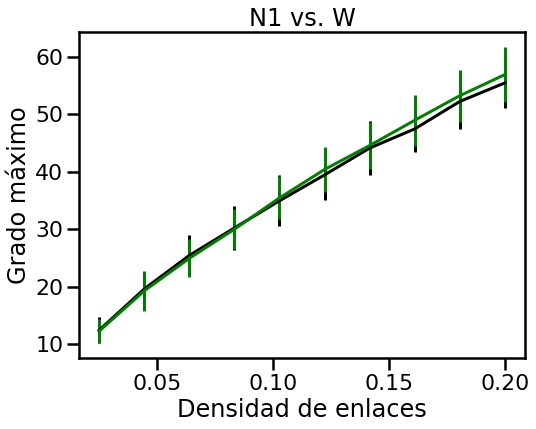

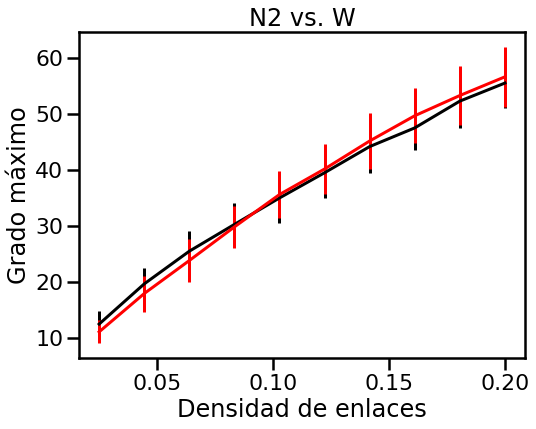

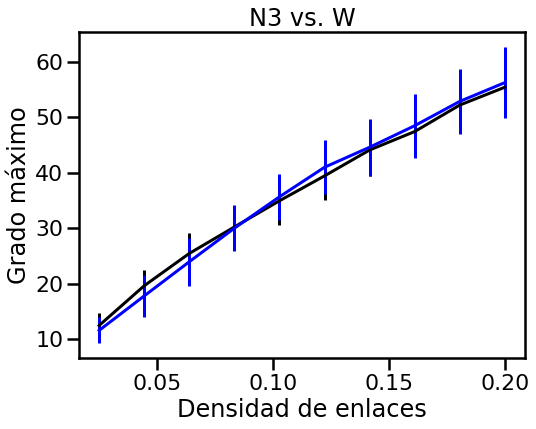

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"maxD",s,"Grado máximo",var_maxD,pairwise_maxD, 5)

In [ ]:
#for s in ["N1","N2","N3"]:
#  plot_var(df_stats,densities,"minD",s,"Grado mínimo",var_minD,pairwise_minD, -0.3)

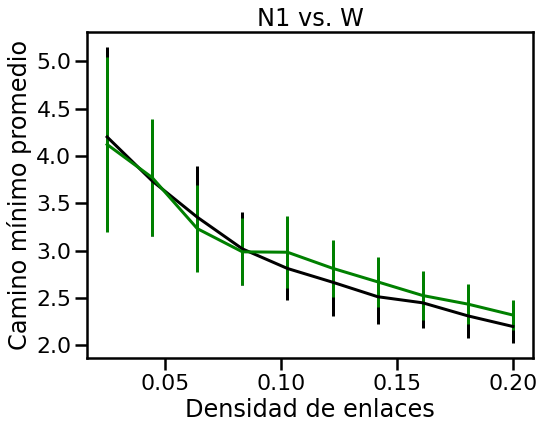

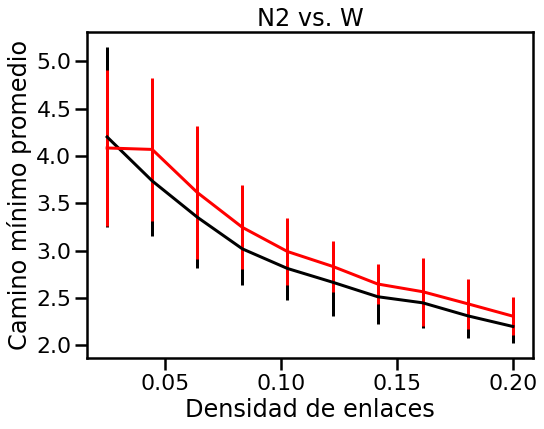

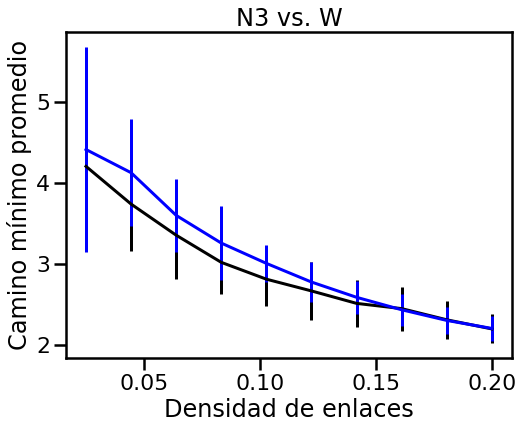

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"spath",s,"Camino mínimo promedio",var_spath,pairwise_spath, 1)

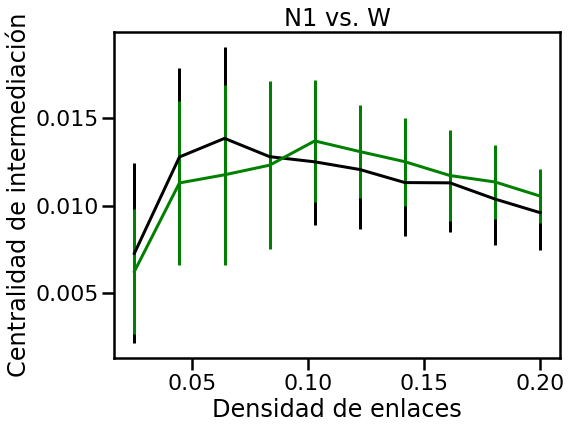

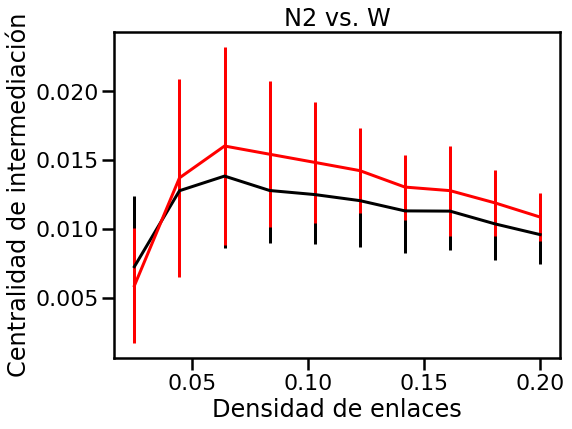

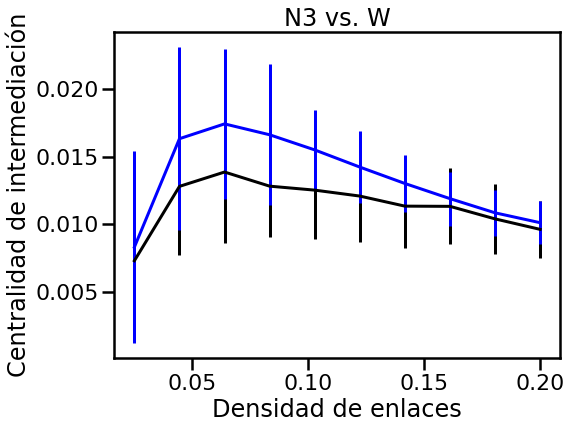

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"betw",s,"Centralidad de intermediación",var_betw,pairwise_betw, 0)

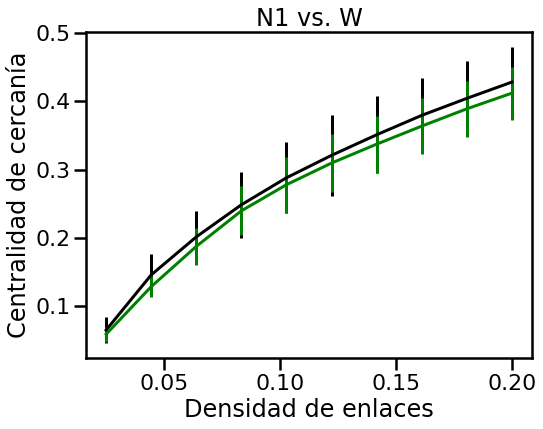

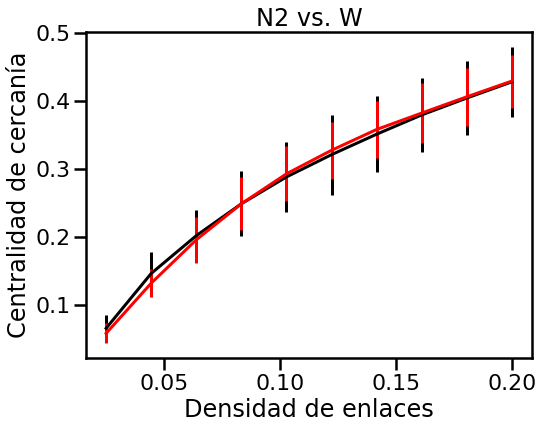

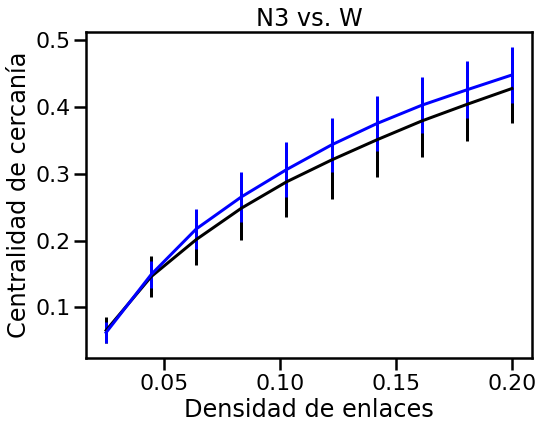

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"close",s,"Centralidad de cercanía",var_close,pairwise_close, 0)

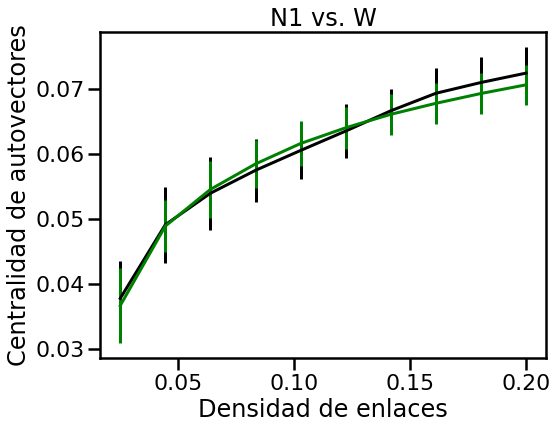

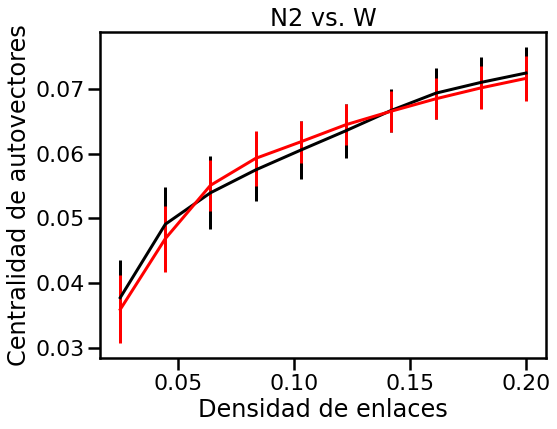

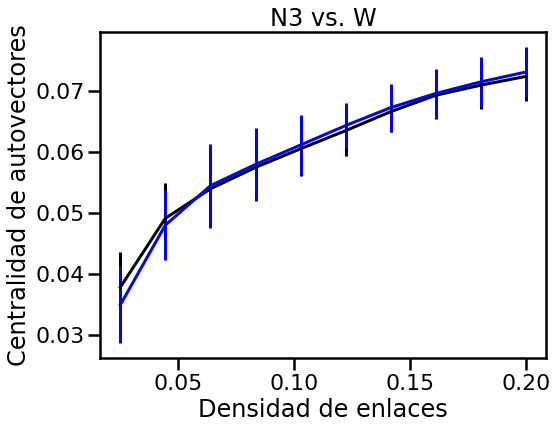

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"eigen",s,"Centralidad de autovectores",var_eigen,pairwise_eigen, 0.025)

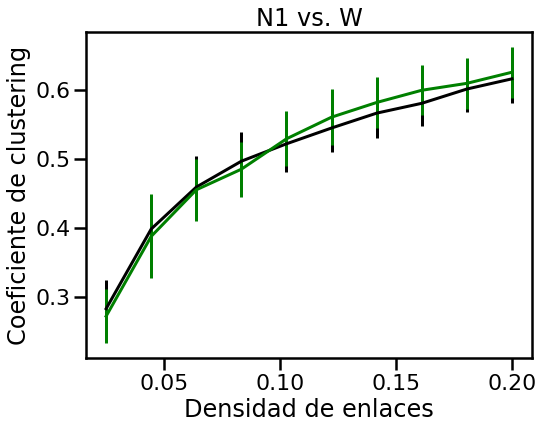

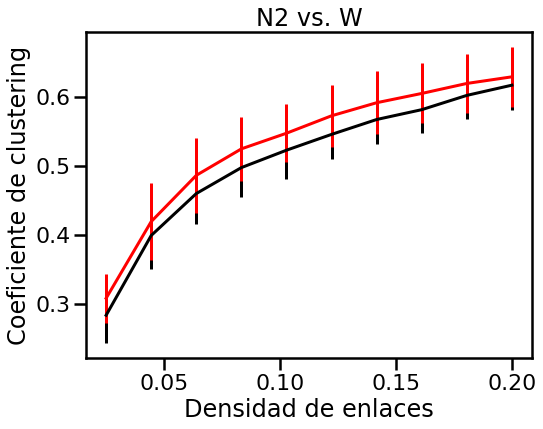

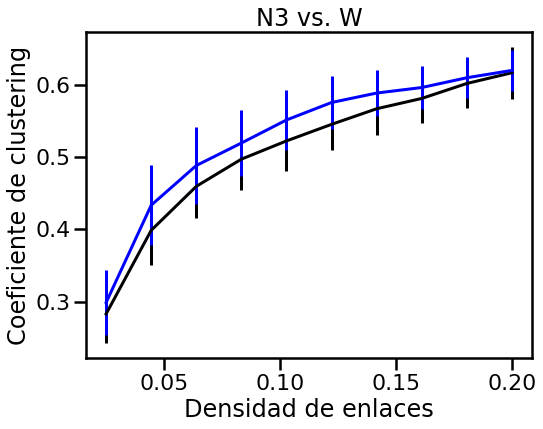

In [ ]:
for s in ["N1","N2","N3"]:
  plot_var(df_stats,densities,"clust",s,"Coeficiente de clustering",var_clust,pairwise_clust, 0.15)